# **文本Embedding基本概念和应用实现原理**

大语言模型之上的应用层面有三项技术需要理解：提示词工程（Prompt Engineering）；嵌入（Embedding）；微调（Fine-tuning）。其中Embedding 作为大语言模型理解文本语义的重要技术，在搜索引擎、构建私有知识问答系统、内容推荐系统等都有相当广泛的应用。

### **Embedding的基本概念**

什么是Embedding，OpenAI官方文档中是这样解释的：

> Embeddings are numerical representations of concepts converted to number sequences, which make it easy for computers to understand the relationships between those concepts.
> 

Embedding是将概念转换为数字序列的数值表示，这使得计算机能够轻松理解这些概念之间的关系。

Embedding也是文本语义含义的信息密集表示，每个嵌入都是一个浮点数向量，使得向量空间中两个嵌入之间的距离与原始格式中两个输入之间的语义相似性相关联。例如，如果两个文本相似，则它们的向量表示也应该相似，这一组向量空间内的数组表示描述了文本之间的细微特征差异。

简单来说，Embedding帮助计算机来理解如人类信息所代表的“含义”，Embedding可以用来获取文本、图像、视频、或其他信息的特征“相关性”，这种相关性在应用层面常用于搜索、推荐、分类、聚类。

### **Embedding是如何工作的？**

举例来讲，这里有三句话：

1. “The cat chases the mouse” “猫追逐老鼠”

2. “The kitten hunts rodents” 小猫捕猎老鼠。

3. “I like ham sandwiches” 我喜欢火腿三明治。

如果是人类来将这三个句子来分类，句子1和句子2几乎是同样的含义，而句子3却完全不同。但我们看到在英文原文句子中，句子1和句子2只有“The”是相同的，没有其他相同词汇。计算机该如何理解前两个句子的相关性？

Embedding将离散信息（单词和符号）压缩为分布式连续值数据（向量）。如果我们将之前的短语绘制在图表上，它可能看起来像这样：

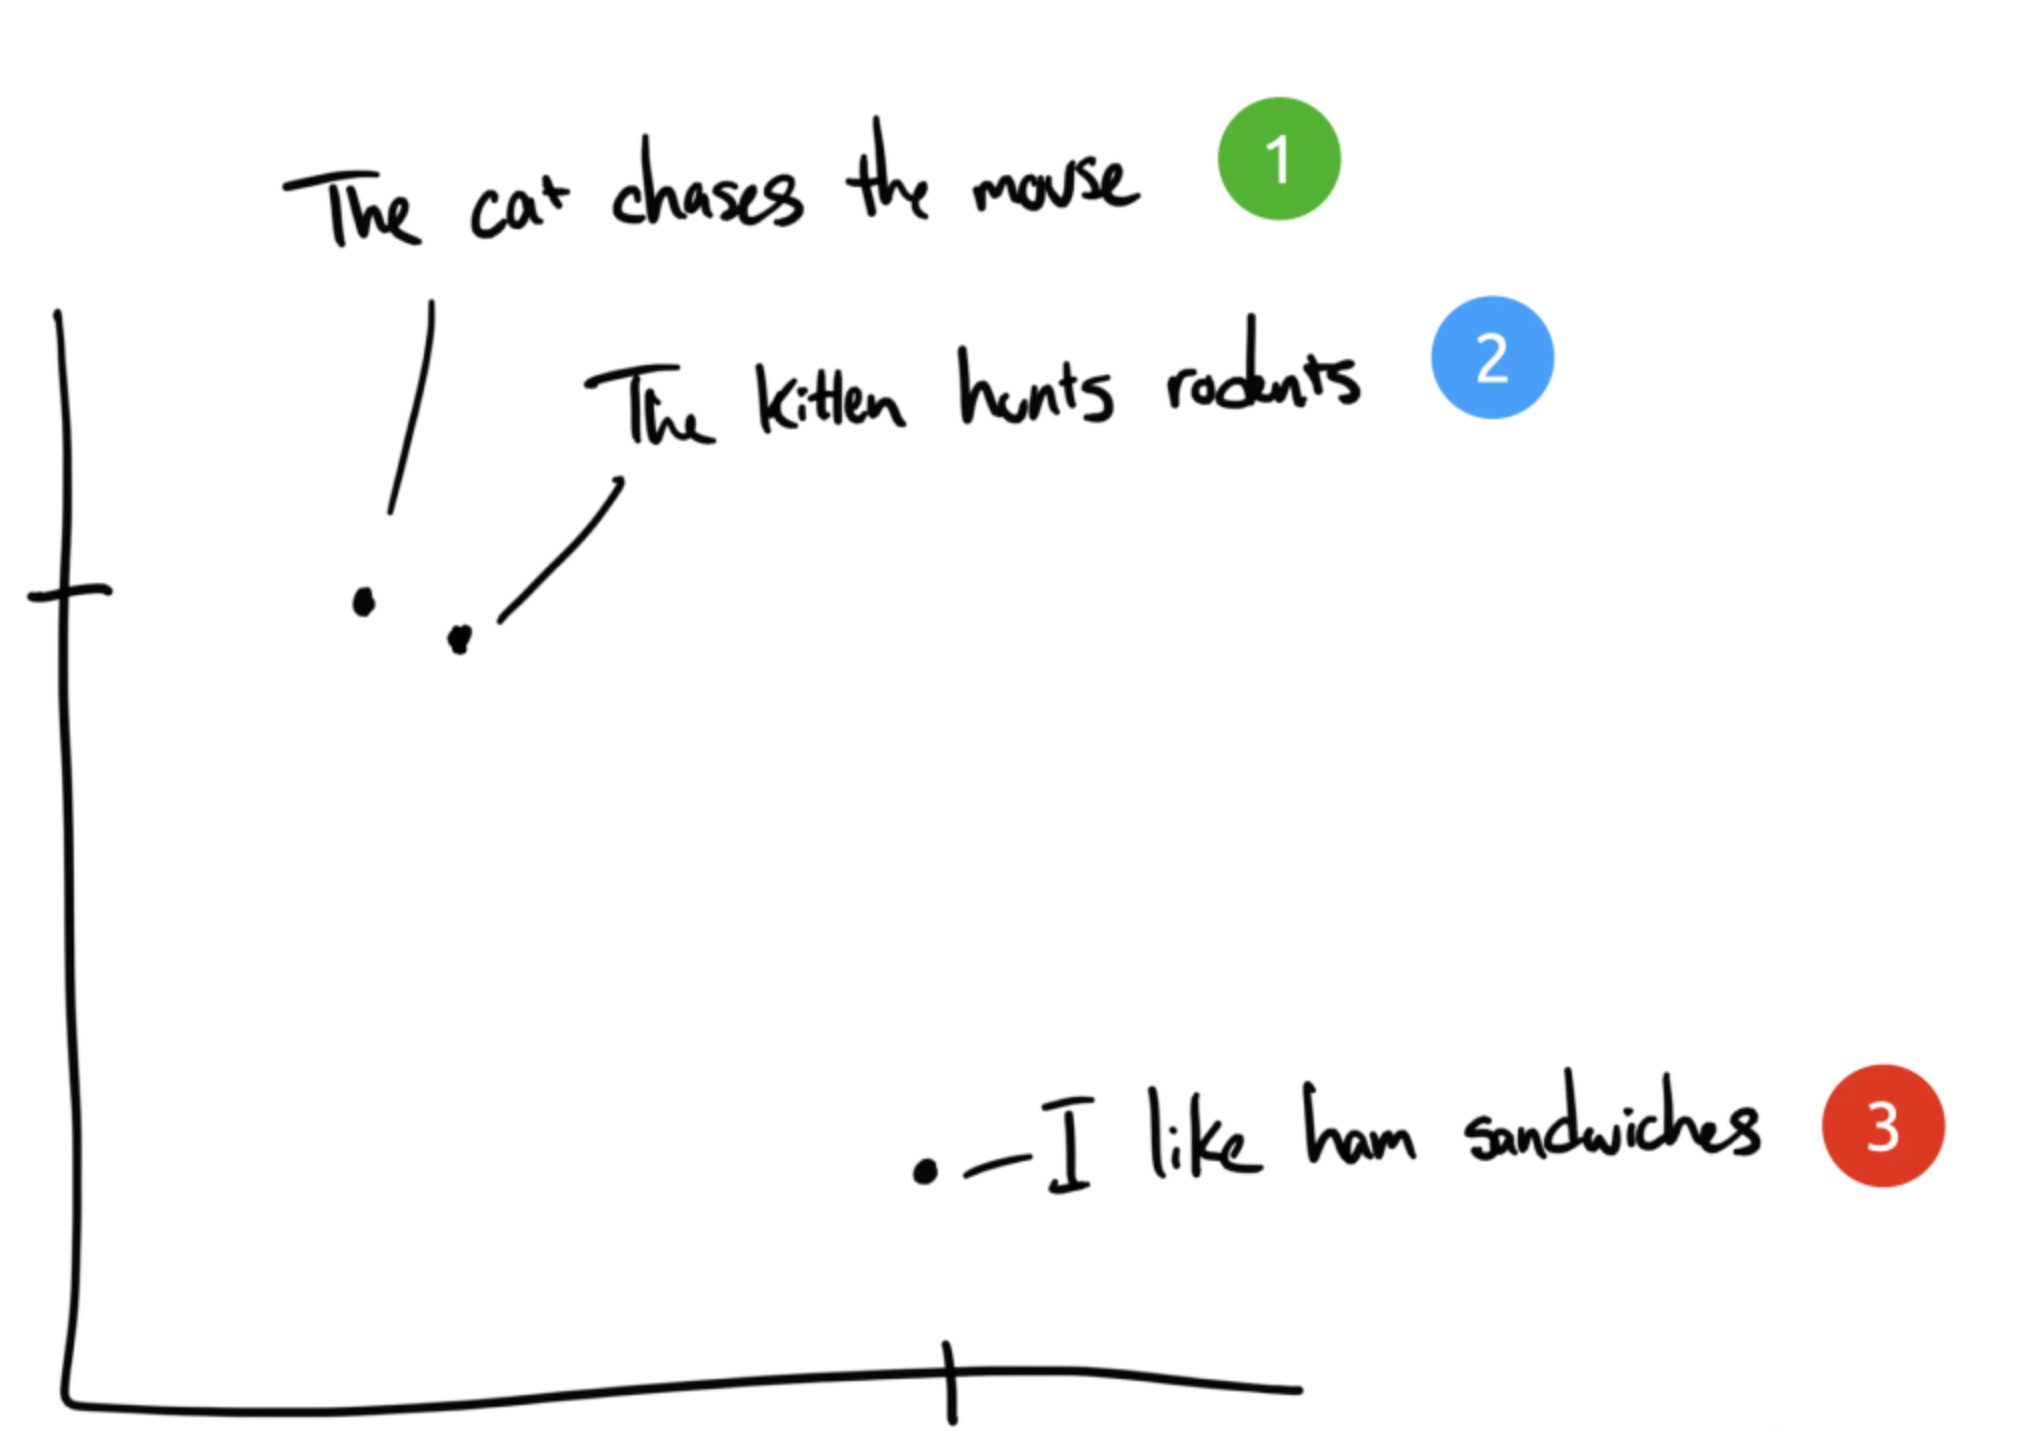

我们可以看到，在文本被Embedding压缩到计算机可以理解的多维向量化空间之后，由于句子1和2的含义相似，它们会被绘制在彼此附近。句子3却距离较远，因为它与它们没有关联。如果我们有第四个短语 “Sally吃了瑞士奶酪”，它可能存在于句子3（奶酪可以放在三明治上）和句子1（老鼠喜欢瑞士奶酪）之间的某个地方。

在这个例子中，我们只有2个维度：X轴和Y轴。实际上，Embedding模型会提供更多的维度来表示人类语言的复杂度。比如OpenAI的Embedding模型text-embedding-ada-002会输出1536个维度。这足以让计算机来理解文本语义的细微差别。对于相似文本的分类，在三维空间内看可能是这样的（见下图），动物、运动员、电影、交通工具、村庄这些文本在空间中的距离是相近的。

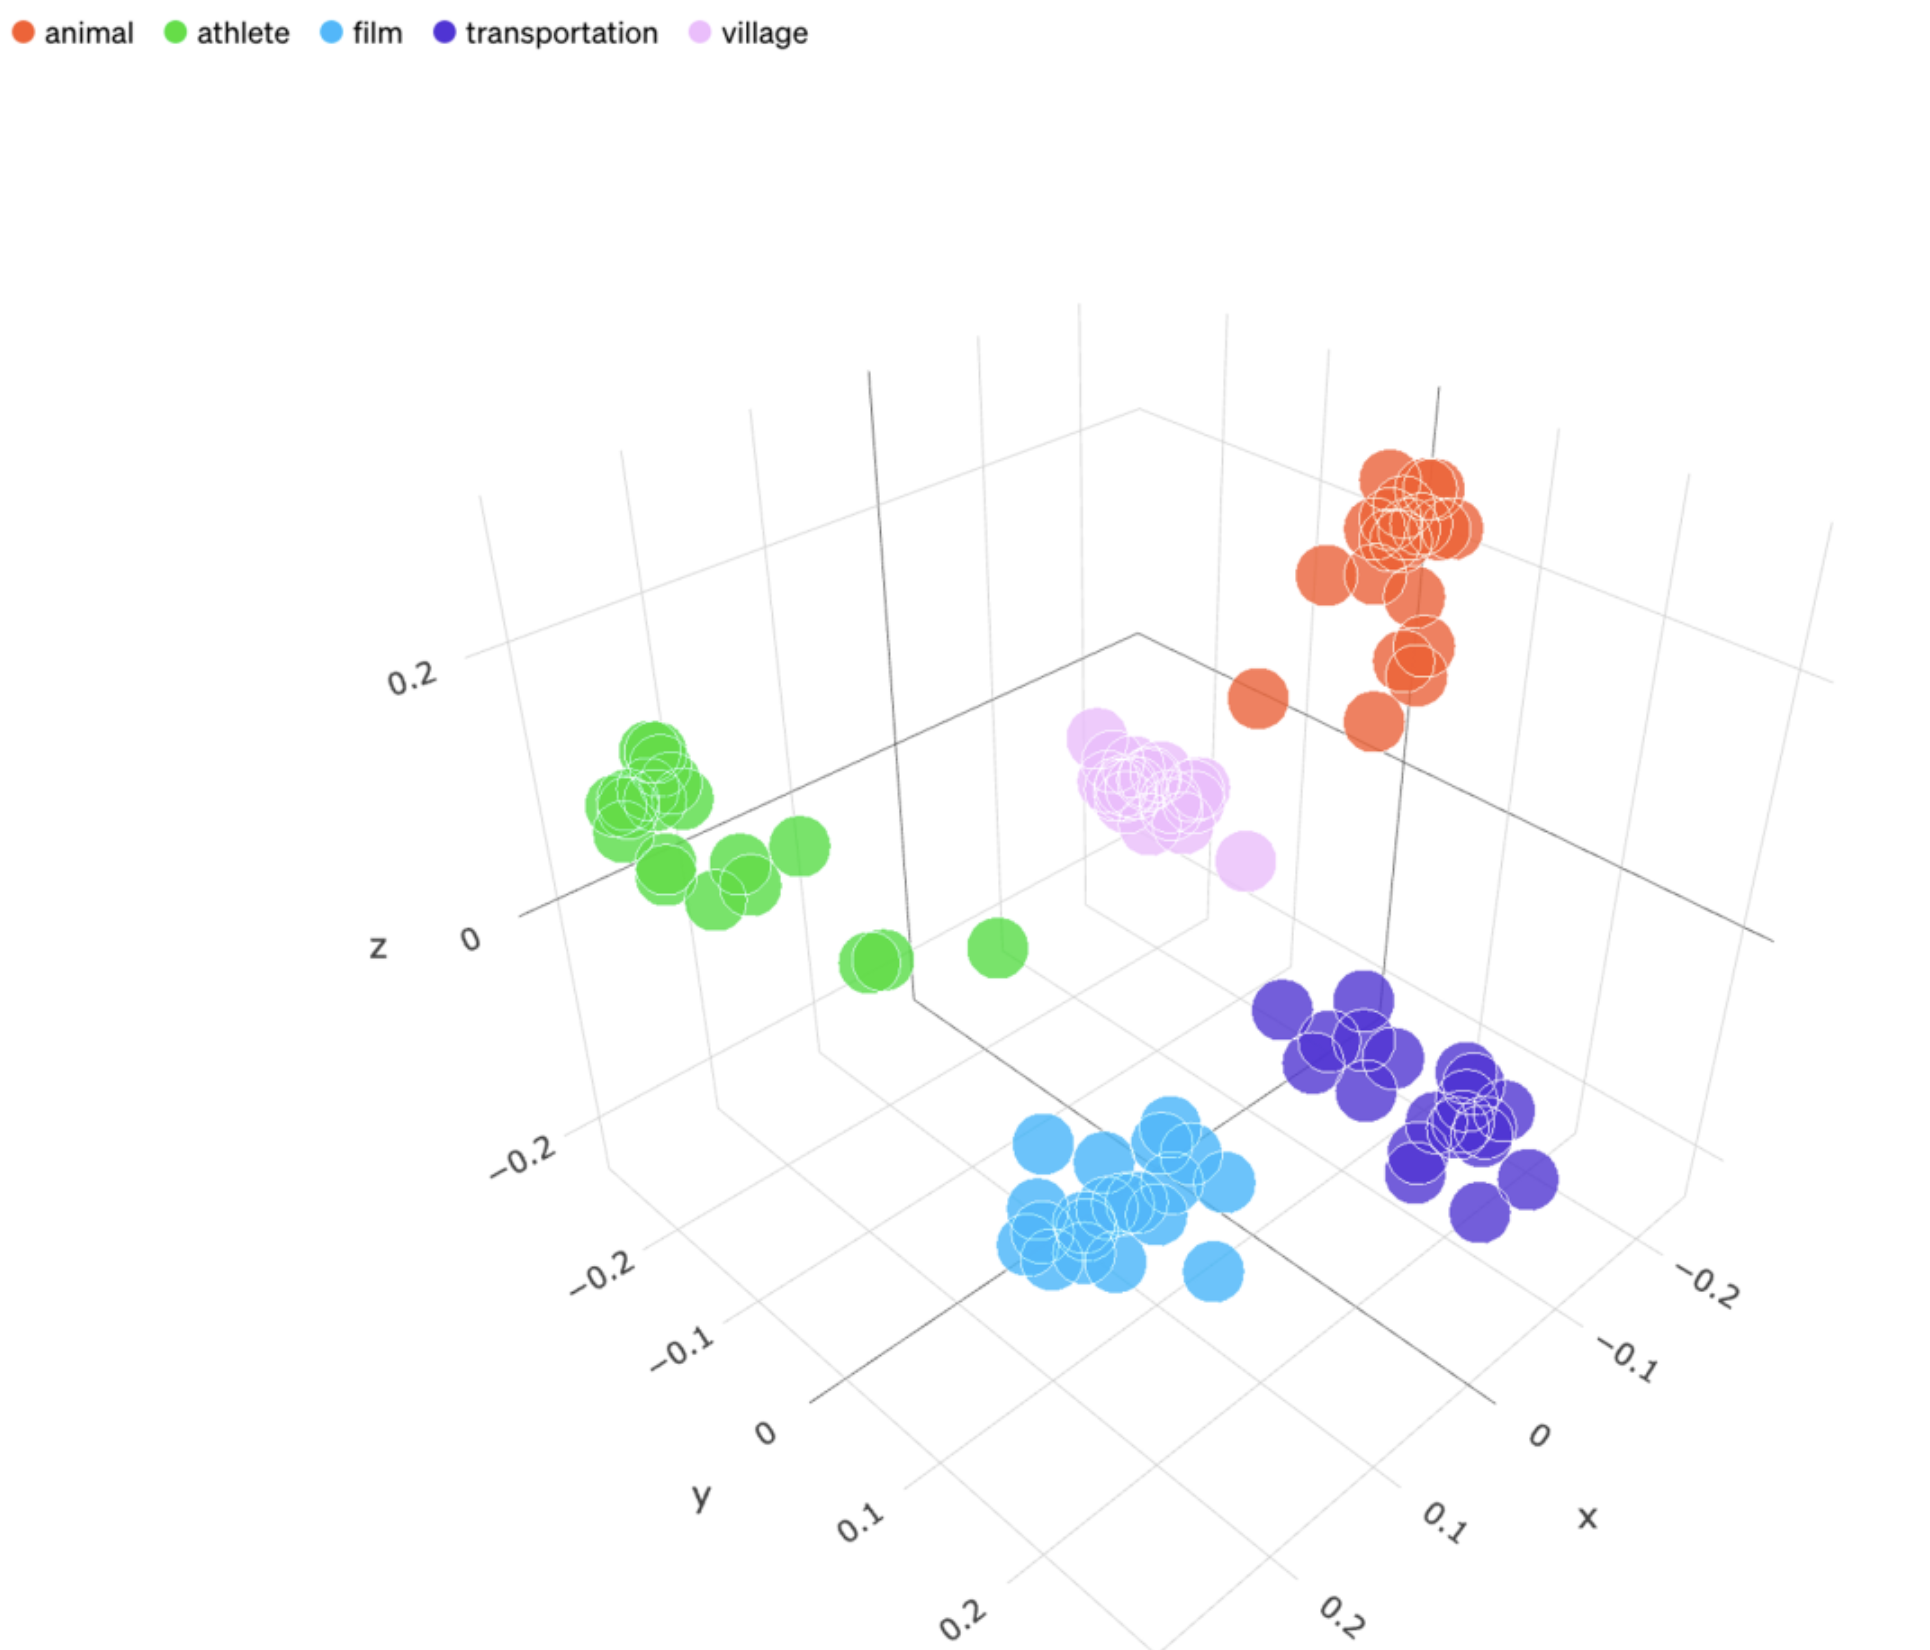

## **Embedding的优势是什么？**

ChatGPT虽然擅长回答问题，但可以回答的范围仅限于它在训练数据中记忆的数据。GPT不擅长回答的问题包括：

- 2021年9月之后的问题；
- 特定领域知识，如医疗、法律、金融等；
- 个人或组织内部的非公开数据；

GPT有两种办法可以学习新知识：

- 通过模型权重（即在训练集上对模型微调）
- 通过模型输入（即将知识做为少样本提示词插入到消息中）

尽管微调可能感觉更自然，毕竟数据训练是GPT学习所有知识的方式，但微调在事实回忆方面并不可靠。类比一下，把大模型比作一个参加考试的学生，模型权重就像长期记忆，当你对模型微调时，就像提前一周准备考试，当考试来临时，模型可能会遗漏掉之前学习过的知识或者错误地回答出从未教授给他的知识。

而使用Embedding的方式，这个学生在考试前什么都不需要准备，在考试时带着一份小抄进了考场，需要回答的问题的时候，就低头看下准备好的小抄，照着小抄来答题相比于记忆（微调）肯定更准确。并且考完试就直接把小抄丢掉，也不用占用任何记忆，整个过程简单易行（对技术实现来讲也是如此）。


### **Embedding的语义检索方式对比关键词检索的优势：**

**语义理解**：基于Embedding的检索方法通过词向量来表示文本，这使得模型能够捕捉到词汇之间的语义联关系，相比之下，基于关键词的检索往往关注字面匹配，可能忽略了词语之间的语义联系。

**容错性**：由于基于Embedding的方法能够理解词汇之间的关系，所以在处理拼写错误、同义词、近义词等情况时更具优势。而基于关键词的检索方法对这些情况的处理相对较弱。

**多语言支持**：许多Embedding方法可以支持多种语言，有助于实现跨语言的文本检索。比如你可以用中文输入来查询英文文本内容，而基于关键词的检索方法很难做到这一点。

**语境理解**：基于Embedding的方法在处理一词多义的情况时更具优势，因为它能够根据上下文为词语赋予不同的向量表示。而基于关键词的检索方法可能无法很好地区分同一个词在不同语境下的含义。

对于语境理解来讲，人类使用词语和符号来交流语言，但是孤立的单词大多没有意义，我们需要从共享的知识和经验中汲取，才能理解它们。比如“你应该谷歌一下”这句话，只有在你知道谷歌是一个搜索引擎，并且人们一直在使用它作为动词时才有意义。同样地，对于有效的自然语言模型来说，也要能够以理解每个单词、短语、句子或段落在不同语境下可能的含义。


# 实验

接下来我们以《劳动法》为例，使用LLM将每条法条表示为一个Embedding向量，然后进行一些基本的向量近似检索实验。
我们将使用阿里开源的qwen模型，使用ollama库来进行本地模型调用，使用chroma向量数据库进行向量存储。

In [1]:
import re

with open("laodongfa.txt", "r") as fp:
    text = fp.read().replace("\u3000", " ")
pattern = r"(  第.*?条.*?)(?=  第.*?条|第.*?章|$)"
matches = re.findall(pattern, text, re.DOTALL)

rules = []
for index, match in enumerate(matches):
    rules.append(match.strip())
# rules中每个元素是一条法条的文本

我们使用qwen:4b模型来为文本计算embedding

ollama是一个本地调用LLM的库

In [2]:
from langchain_community.embeddings.ollama import OllamaEmbeddings

embedding = OllamaEmbeddings(model="qwen:4b")
print(embedding.embed_documents(["你好啊"]))


[[-0.16074761748313904, 18.353322982788086, 1.8791629076004028, 1.6699440479278564, 2.4595043659210205, 7.4938645362854, 3.016930341720581, 4.259737968444824, 1.4110828638076782, 2.4469716548919678, 1.472164273262024, 4.73881196975708, -5.362461566925049, -0.2840634286403656, -6.306908130645752, 2.983499050140381, 1.648193359375, 0.17265577614307404, -1.1411365270614624, -3.3243751525878906, 6.687701225280762, -1.7878261804580688, -1.352903127670288, 1.034665584564209, -28.857215881347656, 4.388082504272461, 0.31274041533470154, 4.096693992614746, -4.637551307678223, 4.106581687927246, 1.2953070402145386, 2.906195640563965, 2.0816569328308105, -3.2777698040008545, 3.0629050731658936, 1.3998079299926758, 1.9177955389022827, -5.15391731262207, 5.018749713897705, -6.577813625335693, -0.3670200705528259, 0.3253405690193176, 1.9581738710403442, -0.20952072739601135, 2.658404588699341, -0.5215789079666138, 1.8315024375915527, -0.24823510646820068, -0.7711488008499146, 0.3576226830482483, 2.5

将所有法条文本，经过上面定义的embedding方法计算成向量，存入 chroma 向量数据库，并且存到persist_directory目录中

In [3]:
from langchain_community.vectorstores.chroma import Chroma

vectorstore = Chroma.from_texts(
    texts=rules,
    embedding=embedding, 
    persist_directory="./laodongfa.emb"
)

接下来我们进行一些搜索尝试，给一段文本，通过向量近似，获取最相关的5个法条。

In [5]:
vectorstore.similarity_search("未成年工定义是什么", k=5)

[Document(page_content='第一条 为了保护劳动者的合法权益，调整劳动关系，建立和维护适应社会主义市场经济的劳动制度，促进经济发展和社会进步，根据宪法，制定本法。'),
 Document(page_content='第五十八条 国家对女职工和未成年工实行特殊劳动保护。\n  未成年工是指年满十六周岁未满十八周岁的劳动者。'),
 Document(page_content='第三十六条 国家实行劳动者每日工作时间不超过八小时、平均每周工作时间不超过四十四小时的工时制度。'),
 Document(page_content='第四十五条 国家实行带薪年休假制度。\n  劳动者连续工作一年以上的，享受带薪年休假。具体办法由国务院规定。'),
 Document(page_content='第十五条 禁止用人单位招用未满十六周岁的未成年人。文艺、体育和特种工艺单位招用未满十六周岁的未成年人，必须依照国家有关规定，履行审批手续，并保障其接受义务教育的权利。')]

In [6]:
vectorstore.similarity_search("每日工作时间不能超过多少？", k=5)

[Document(page_content='第一条 为了保护劳动者的合法权益，调整劳动关系，建立和维护适应社会主义市场经济的劳动制度，促进经济发展和社会进步，根据宪法，制定本法。'),
 Document(page_content='第五十六条 劳动者在劳动过程中必须严格遵守安全操作规程。\n  劳动者对用人单位管理人员违章指挥、强令冒险作业，有权拒绝执行；对危害生命安全和身体健康的行为，有权提出批评、检举和控告。'),
 Document(page_content='第四十五条 国家实行带薪年休假制度。\n  劳动者连续工作一年以上的，享受带薪年休假。具体办法由国务院规定。'),
 Document(page_content='第十条 国家通过促进经济和社会发展，创造就业条件，扩大就业机会。国家鼓励企业、事业组织、社会团体在法律、行政法规规定的范围内兴办产业或者拓展经营，增加就业。国家支持劳动者自愿组织起来就业和从事个体经营实现就业。'),
 Document(page_content='第三十六条 国家实行劳动者每日工作时间不超过八小时、平均每周工作时间不超过四十四小时的工时制度。')]

In [7]:
vectorstore.similarity_search("公司暴力裁员，我该怎么办？", k=5)

[Document(page_content='第一条 为了保护劳动者的合法权益，调整劳动关系，建立和维护适应社会主义市场经济的劳动制度，促进经济发展和社会进步，根据宪法，制定本法。'),
 Document(page_content='第七条 劳动者有权依法参加和组织工会。工会代表和维护劳动者的合法权益，依法独立自主地开展活动。'),
 Document(page_content='第一百零五条 违反本法规定侵害劳动者合法权益，其他法律、法规已规定处罚的，依照该法律、行政法规的规定处罚。'),
 Document(page_content='第十条 国家通过促进经济和社会发展，创造就业条件，扩大就业机会。国家鼓励企业、事业组织、社会团体在法律、行政法规规定的范围内兴办产业或者拓展经营，增加就业。国家支持劳动者自愿组织起来就业和从事个体经营实现就业。'),
 Document(page_content='第三十四条 集体合同签订后应当报送劳动行政部门；劳动行政部门自收到集体合同文本之日起十五日内未提出异议的，集体合同即行生效。')]

可以看到，前两个 case 都查询到了相关的文档，但最后一个 case 搜索出来的内容都不是很相关，说明目前这种语义近似的检索也是有缺陷的。

回顾一下，本节课程我们学习了如何使用ollama来对文本进行向量化，以及使用chroma向量库来进行向量近似检索。